In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


# Generate a count matrix of random noise

We want our factor model to tell us that this is just noise

In [2]:
N = 50000
D = 30
P = 4

# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': np.random.poisson(1.0, size=(N, D)),
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(1000)


Currently, the input data has to be in this format, as a tensorflow BatchDataset object with the given key/values.

# Set up the inference object

In [3]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    u_tau_scale=1.0/np.sqrt(D*N),
    with_s = False,
    dtype=tf.float64)
# Test to make sure sampling works


Feature dim: 30 -> Latent dim 4


## Test out the prior distributions

In [4]:
## 
sample = factor.joint_prior.sample(10)
# Compute the joint log probability of the sample
probs = factor.joint_prior.log_prob(sample)
sample_surrogate = factor.surrogate_distribution.sample(77)
probs_parts = factor.unormalized_log_prob_parts(
    **sample_surrogate, data=next(iter(data)))
prob = factor.unormalized_log_prob(
    **sample_surrogate,  data=next(iter(data)))



# Inference

In [5]:
losses = factor.calibrate_advi(
    num_epochs=200, rel_tol=1e-4, learning_rate=.05)



W0604 09:11:19.534935 4508687808 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 45.3364585161593
Epoch 1: average-batch loss: 44.8091410891739 last batch loss: 44.352845967826894
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 44.1103600899719 last batch loss: 43.67874013577645
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 43.474774775799794 last batch loss: 43.032201292467
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 42.86620862844085 last batch loss: 42.4888807334852
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 42.284461141620675 last batch loss: 41.880361895052765
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 41.73807700002275 last batch loss: 41.360938291024475
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 41.25795730845116 last batch loss: 40.95360044279759
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 40.957675261237846 last batch loss: 40.77136989079809
Saved a checkpoint: ./.tf_ckpts/

Epoch 74: average-batch loss: 40.79471512178981 last batch loss: 40.67667144545897
Epoch 75: average-batch loss: 40.79255714976342 last batch loss: 40.68066631609163
Epoch 76: average-batch loss: 40.7930808393333 last batch loss: 40.691848279664434
Epoch 77: average-batch loss: 40.793401568300375 last batch loss: 40.68570344732729
We are in a loss plateau learning rate: 0.017433922005000005 loss: 40.87551079641578
Restoring from a checkpoint - loss: 40.87247451926742
Epoch 78: average-batch loss: 40.79524000576841 last batch loss: 40.6889208659308
Epoch 79: average-batch loss: 40.795019247486515 last batch loss: 40.681268656685475
Epoch 80: average-batch loss: 40.79458962923129 last batch loss: 40.675147600458125
Epoch 81: average-batch loss: 40.79459210584482 last batch loss: 40.680139118911896
Epoch 82: average-batch loss: 40.79455680606617 last batch loss: 40.67166904229694
Epoch 83: average-batch loss: 40.792733262330714 last batch loss: 40.66924246436968
Epoch 84: average-batch lo

Epoch 153: average-batch loss: 40.79367312996732 last batch loss: 40.677554448129264
Epoch 154: average-batch loss: 40.794475694514766 last batch loss: 40.67711397838732
Epoch 155: average-batch loss: 40.79362771295935 last batch loss: 40.689156418450835
Epoch 156: average-batch loss: 40.79322875660715 last batch loss: 40.67312739422111
Epoch 157: average-batch loss: 40.79365115312393 last batch loss: 40.68564590698834
We are in a loss plateau learning rate: 0.00492385451091806 loss: 40.86726053739391
Restoring from a checkpoint - loss: 40.87039931238333
Epoch 158: average-batch loss: 40.7932660899077 last batch loss: 40.67410668525635
Epoch 159: average-batch loss: 40.793802343983174 last batch loss: 40.69187215848925
Epoch 160: average-batch loss: 40.79381308179286 last batch loss: 40.67374648113899
Epoch 161: average-batch loss: 40.79123340385533 last batch loss: 40.66242195258337
Epoch 162: average-batch loss: 40.794831358001616 last batch loss: 40.681694040664546
We are in a loss 

# Compute the WAIC

In [6]:
waic = factor.waic()
print(waic)

{'waic': 353876.30343621323, 'se': 1806.6618645424037, 'lppd': -37679.28337124284, 'pwaic': 139258.86834686378}


# Plot the factor encoding matrix

In [7]:

surrogate_samples = factor.surrogate_distribution.sample(1000)
if 's' in surrogate_samples.keys():
    weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
    intercept_data = az.convert_to_inference_data(
        {
            r"$w_d$": 
                (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor.column_norm_factor).numpy().T})
else:
    intercept_data = az.convert_to_inference_data(
    {
        r"$w_d$": 
            (tf.squeeze(surrogate_samples['w'])*factor.column_norm_factor).numpy().T})

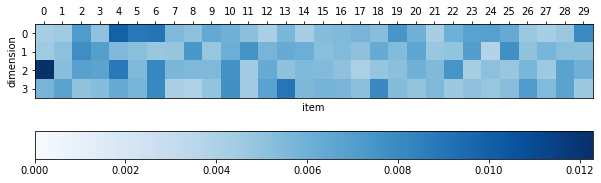

In [8]:
fig, ax = plt.subplots(figsize=(10,4))

plt.imshow(factor.encoding_matrix().numpy().T, vmin=0, cmap="Blues")
plt.xticks(np.arange(D))
ax.set_xlabel("item")
ax.set_ylabel("dimension")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.yticks(np.arange(P))
plt.colorbar(orientation = "horizontal")
plt.show()


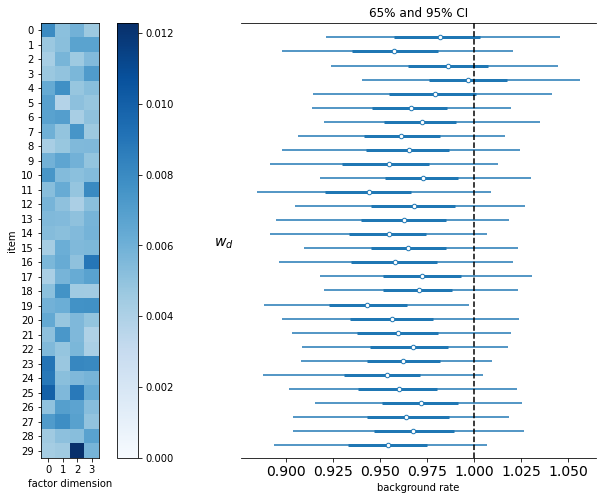

In [9]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
#plt.savefig('noise_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()


The values in the factor encoding matrix as near zero. There is a gradient because the model induces a dimensional decay to remove symmetries - this encourages the leading dimensions to hold more of the signal.

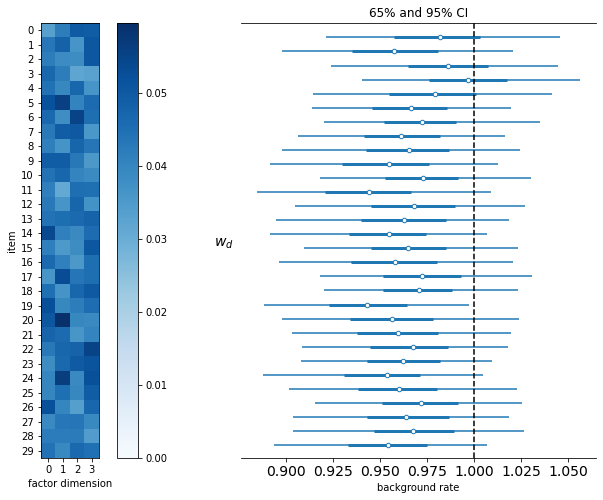

In [10]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.decoding_matrix().numpy().T[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
plt.show()


In [11]:
factor.decoding_matrix().numpy().dot(factor.encoding_matrix().numpy())

array([[0.00782121, 0.0076213 , 0.00792446, 0.00767291],
       [0.00787555, 0.00743648, 0.00787597, 0.00754283],
       [0.00765256, 0.00735177, 0.00768568, 0.00738041],
       [0.00793763, 0.00761211, 0.00800334, 0.00772342]])

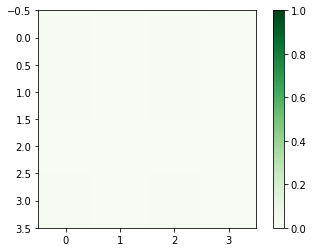

In [12]:
plt.imshow(factor.decoding_matrix().numpy().dot(factor.encoding_matrix().numpy()),cmap="Greens", vmin=0, vmax=1)
plt.colorbar()